# Classification Tests on Twitter dataset

spiegazione test

### Imports

In [1]:
import re
import xml.etree.ElementTree as ET
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import it_core_news_sm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import collections
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
# Skopt functions
from sklearn.metrics import make_scorer, f1_score, recall_score
from skopt import BayesSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from skopt import gp_minimize # Bayesian optimization using Gaussian Processes
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import math
import scipy.stats
import sys
from info_gain import info_gain
from copy import copy, deepcopy
import re
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
import pickle

In [2]:
# nltk.download('averaged_perceptron_tagger')

## Functions

In [3]:
def tokenize(text):
        tokens = nltk.word_tokenize(text, 'english')
        english_stopwords = stopwords.words('english')
        return [token for token in tokens if not token in english_stopwords]
    
def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' emo_pos ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' emo_pos ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' emo_pos ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', ' emo_pos ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' emo_neg ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' emo_neg ', tweet)
    return tweet

def preprocess_word(word):
    # remove punctation
    word = word.strip('\'"?!,.():;*')
    # more than 3 letter repetition removed
    word = re.sub(r'(.)\1\1+', r'\1\1\1', word)
    # remove - & '
    word = word.strip('-&\'')
    return word

def is_valid_word(word):
    # Check if word begins with an alphabet
    return (re.search(r'^[a-zA-Z][a-z0-9A-Z\._]*$', word) is not None)


In [4]:
class Preprocessor:

    # preprocess text
    # allowed methods: word, swnt, pos
    # ner (named entity recognition), replacing for instance 100 km/h with SPEED
    def preprocessText(self, tweet, method='word', use_stemmer=False, ner=False):
        if method not in ['word', 'pos', 'swnt']:
            raise ValueError('Method not recognized. Select from word, swnt, pos')
            
        # lowercase
        tweet = tweet.lower()
        # replace 2+ dots with space
        tweet = re.sub(r'\.{2,}', ' ', tweet)
        # remove space, " and ' 
        tweet.strip('" \'')
            
        # NOW DEPENDS ON NER
        if ner:
            # replace urls with 'URL'
            tweet = re.sub(r'((www.[\S]+)|(https?://.[\S]+))', 'url', tweet)
            # replace user mentions @user with 'USER_MENTION'
            tweet = re.sub(r'@[\S]+', 'user_mention', tweet)
            # replace #hashtag with hastag
            tweet = re.sub(r'#(\S+)', r' \1', tweet)
            # remove retweet RT
            tweet = re.sub(r'\brt\b', '', tweet)
            # handle emojis. Use only EMO_POS and EMO_NEG
            tweet = handle_emojis(tweet)
            # replace multiple spaces with only one space
            tweet = re.sub(r'\s+', ' ', tweet)
        
        # NOW DEPENDS ON METHOD
        if method == 'word':
            # just do nothing except eventually stemming
            words = tokenize(tweet)
            processed_words = []
            porter_stemmer = PorterStemmer()
            for word in words:
                word = preprocess_word(word)
                if use_stemmer:
                    # use stemmer
                    word = str(porter_stemmer.stem(word))
                processed_words.append(word)
            return ' '.join(processed_words)
                    
        elif method == 'swnt':
            # substitute words with their sentiment grade
            words = tokenize(tweet)
            processed_words = []
            porter_stemmer = PorterStemmer()
            for word in words:
                word = preprocess_word(word)
                
                list_swn = list(swn.senti_synsets(word))
                if len(list_swn) > 0:
                    s_p = list_swn[0].pos_score()
                    s_ne = list_swn[0].obj_score()
                    s_n = list_swn[0].neg_score()
                    if s_ne > s_p and s_ne > s_n:
                        word = str(porter_stemmer.stem(word))
                        processed_words.append(word)
                    elif s_p > s_n:
                        processed_words.append('pos_' + str(int(s_p)))
                    elif s_n > s_p:
                        processed_words.append('neg_' + str(int(s_n)))
                else:
                    if use_stemmer:
                        # use stemmer
                        word = str(porter_stemmer.stem(word))
                        processed_words.append(word)
            return ' '.join(processed_words)
            
        elif method == 'pos':
            porter_stemmer = PorterStemmer()
            words = tokenize(tweet)
            pos = nltk.pos_tag(words)
            pos_list = []
            pos_word_list = []
            pos_word_list_fin = []
            for p in pos:
                pos_list.append(p[1])
                pos_word_list.append(p[1] + '_' + p[0])
            if use_stemmer:
                for t in pos_word_list:
                    pos_word_list_fin.append(str(porter_stemmer.stem(t)))
            else:
                pos_word_list_fin = pos_word_list
            return ' '.join(pos_list + pos_word_list_fin)

In [5]:
pp = Preprocessor()
pp.preprocessText(tweet='@VirginAmerica What @dhepburn said.', method='pos', use_stemmer=True, ner=True)

'NN NN VBD . nn_user_ment nn_user_ment vbd_said ._.'

In [6]:
dataset = pd.read_csv('tsa/twitter-airline-sentiment.csv')
dataset

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)
7,570300248553349120,neutral,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,@VirginAmerica Really missed a prime opportuni...,NaN,2015-02-24 11:12:29 -0800,Los Angeles,Pacific Time (US & Canada)
8,570299953286942721,positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,2015-02-24 11:11:19 -0800,San Diego,Pacific Time (US & Canada)
9,570295459631263746,positive,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada)


In [7]:
collections.Counter(dataset['airline_sentiment'])

Counter({'neutral': 3099, 'positive': 2363, 'negative': 9178})

Undersampling

In [8]:
positive = dataset.query('airline_sentiment == "positive"')['text']
negative = dataset.query('airline_sentiment == "negative"')['text']
neutral = dataset.query('airline_sentiment == "neutral"')['text']

In [18]:
np_positive = positive.values
np_negative = negative.values
np_neutral = neutral.values

# shuffle
np.random.seed(10)
np.random.shuffle(np_positive)
np.random.shuffle(np_negative)
np.random.shuffle(np_neutral)

# take the same number of sentences
cut = 1500 # min(len(np_positive), len(np_negative), len(np_neutral))
np_positive = np_positive[:cut]
np_negative = np_negative[:cut]
np_neutral = np_neutral[:cut]

In [19]:
# positive=0, neutral=1, negative=2
dataset_us_X = []
dataset_us_y = []
dataset_us_X.extend(np_positive)
dataset_us_y.extend(np.ones(len(np_positive)) * 0)
dataset_us_X.extend(np_neutral)
dataset_us_y.extend(np.ones(len(np_neutral)) * 1)
dataset_us_X.extend(np_negative)
dataset_us_y.extend(np.ones(len(np_negative)) * 2)

Train Validation Test split

In [20]:
np.random.seed(42)
# split 80% training and 20% test
# FARLO RISPETTANDO LA DISTRIBUZIONE
train_dataset_X, test_dataset_X, train_dataset_y, test_dataset_y = train_test_split(dataset_us_X, dataset_us_y, test_size=0.2, stratify=dataset_us_y, shuffle=True, random_state=52)
# split validation
train_dataset_X, valid_dataset_X, train_dataset_y, valid_dataset_y = train_test_split(train_dataset_X, train_dataset_y, test_size=0.2, stratify=train_dataset_y, shuffle=True, random_state=52)

In [21]:
collections.Counter(train_dataset_y)

Counter({2.0: 960, 1.0: 960, 0.0: 960})

Preprocessing Example

In [22]:
print('######## POSITIVE ########')
print(np_positive[0])
print(pp.preprocessText(np_positive[0], use_stemmer=True, ner=True))
print('######## NEGATIVE ########')
print(np_negative[0])
print(pp.preprocessText(np_negative[0], use_stemmer=True, ner=True))
print('######## NEUTRAL ########')
print(np_neutral[0])
print(pp.preprocessText(np_neutral[0], use_stemmer=True, ner=True))

######## POSITIVE ########
@AmericanAir Thank you!!!! I will be there to pick her up on time.
user_ment thank     pick time 
######## NEGATIVE ########
@USAirways ANSWER THE BLOODY PHONE!
user_ment answer bloodi phone 
######## NEUTRAL ########
@united I do not see where it talks about military baggage fees. Can you please guide me. Thanks
user_ment see talk militari baggag fee  pleas guid  thank


In [23]:
pp = Preprocessor()
# positive
train_dataset_X_pp = []
for tweet in train_dataset_X:
    train_dataset_X_pp.append(pp.preprocessText(tweet=tweet, use_stemmer=True, ner=True))
# negative
valid_dataset_X_pp = []
for tweet in valid_dataset_X:
    valid_dataset_X_pp.append(pp.preprocessText(tweet=tweet, use_stemmer=True, ner=True))
# neutral
test_dataset_X_pp = []
for tweet in test_dataset_X:
    test_dataset_X_pp.append(pp.preprocessText(tweet=tweet, use_stemmer=True, ner=True))

Vectorization

In [24]:
vec = TfidfVectorizer(ngram_range=(1,2), lowercase=True)

train_X = vec.fit_transform(train_dataset_X_pp)
train_y = train_dataset_y
valid_X = vec.transform(valid_dataset_X_pp)
valid_y = valid_dataset_y
test_X = vec.transform(test_dataset_X_pp)
test_y = test_dataset_y

In [25]:
train_X

<2880x22486 sparse matrix of type '<class 'numpy.float64'>'
	with 50006 stored elements in Compressed Sparse Row format>

## Sentiment Classification

SVM_TFIDF_Classifier without feaure selection

In [26]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)

svm_clf = svm.SVC(kernel='linear', decision_function_shape='ovr', verbose=2, random_state=42)

tuned_parameters = {'C': np.logspace(-3, 3, 7),}

# f1, f1_macro (for multiclass), recall
scores = ['f1_macro']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(svm_clf, tuned_parameters, cv=skf, n_jobs=-1, scoring=score, verbose=2)
    clf.fit(train_X, train_y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

# Tuning hyper-parameters for f1_macro

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   11.6s finished


[LibSVM]Best parameters set found on development set:

{'C': 1.0}

Grid scores on development set:

0.265 (+/-0.086) for {'C': 0.001}
0.265 (+/-0.086) for {'C': 0.01}
0.412 (+/-0.061) for {'C': 0.1}
0.706 (+/-0.058) for {'C': 1.0}
0.692 (+/-0.049) for {'C': 10.0}
0.692 (+/-0.049) for {'C': 100.0}
0.692 (+/-0.049) for {'C': 1000.0}



In [27]:
# predictions
pred = clf.best_estimator_.predict(valid_X)

F1 score macro on validation data: 0.7336758246118715
F1 score micro on validation data: 0.7333333333333333


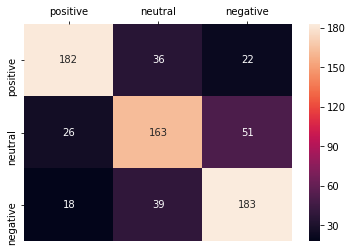

In [28]:
# 0=positivo, 1=neutro, 2=negativo
print('F1 score macro on validation data: ' + str(f1_score(valid_y, pred, average='macro')))
print('F1 score micro on validation data: ' + str(f1_score(valid_y, pred, average='micro')))
cm = confusion_matrix(valid_y, pred, labels=[0, 1, 2])
ax = sns.heatmap(cm, annot=True, xticklabels=['positive','neutral','negative'], yticklabels=['positive','neutral','negative'], fmt="d")
ax.xaxis.set_ticks_position('top')

Feature Selection

In [29]:
weights = clf.best_estimator_.coef_
print(weights.shape)
# 6 perchè fa un classifictore per ogni coppia di labels (ovr) -> verificare

(3, 22486)


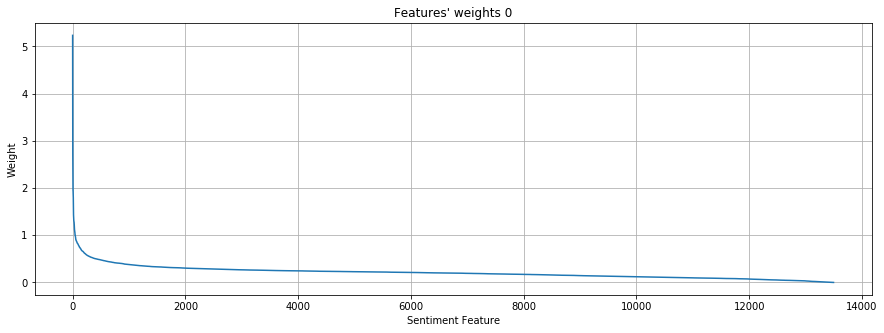

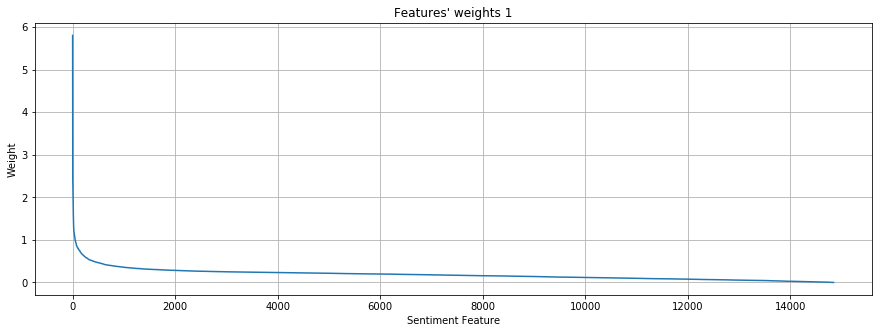

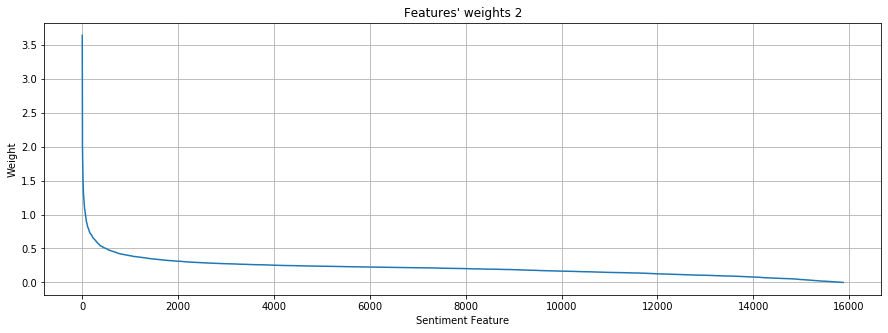

In [30]:
# Data for plotting
for i in range(weights.shape[0]):
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(range(weights[i].data.shape[0]), sorted(abs(weights[i].data), reverse = True))
    ax.set(xlabel='Sentiment Feature', ylabel='Weight', title='Features\' weights ' + str(i))
    ax.grid()
    #fig.savefig("test.png")
    plt.show()

In [31]:
# select most important features
cutoff_0 = 0.3
selected_features_0 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights[0].data)), weights[0].indices), reverse=True) if i[0] > cutoff_0]
cutoff_1 = 0.3
selected_features_1 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights[1].data)), weights[1].indices), reverse=True) if i[0] > cutoff_1]
cutoff_2 = 0.2
selected_features_2 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights[2].data)), weights[2].indices), reverse=True) if i[0] > cutoff_2]

In [32]:
# take the union of selected features (a word important for a classification may be not important for other classifications)
selected_features = set()
for f in selected_features_0:
    selected_features.add(f[1])
for f in selected_features_1:
    selected_features.add(f[1])
for f in selected_features_2:
    selected_features.add(f[1])
print('Selected ' + str(len(selected_features)) + ' features')    

Selected 9564 features


Retry with selected features

In [33]:
train_X_fs = train_X[:, list(selected_features)]
train_y_fs = train_y
valid_X_fs = valid_X[:, list(selected_features)]
valid_y_fs = valid_y

In [34]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)

svm_clf_fs = svm.SVC(kernel='linear', decision_function_shape='ovr', verbose=2, random_state=42)

tuned_parameters = {'C': np.logspace(-3, 3, 7),}

scores = ['f1_macro']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf_fs = GridSearchCV(svm_clf_fs, tuned_parameters, cv=skf, n_jobs=-1, scoring=score, verbose=2)
    clf_fs.fit(train_X_fs, train_y_fs)

    print("Best parameters set found on development set:")
    print()
    print(clf_fs.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf_fs.cv_results_['mean_test_score']
    stds = clf_fs.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf_fs.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

# Tuning hyper-parameters for f1_macro

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   11.7s finished


[LibSVM]Best parameters set found on development set:

{'C': 10.0}

Grid scores on development set:

0.246 (+/-0.066) for {'C': 0.001}
0.246 (+/-0.066) for {'C': 0.01}
0.381 (+/-0.072) for {'C': 0.1}
0.740 (+/-0.043) for {'C': 1.0}
0.742 (+/-0.037) for {'C': 10.0}
0.725 (+/-0.031) for {'C': 100.0}
0.700 (+/-0.038) for {'C': 1000.0}



In [35]:
# predictions
pred_fs = clf_fs.best_estimator_.predict(valid_X_fs)

F1 macro score on validation data: 0.7015905272812031
F1 micro score on validation data: 0.7041666666666667


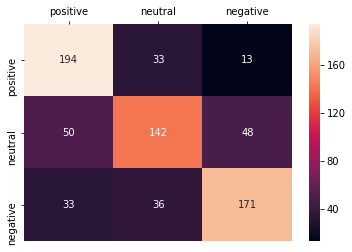

In [36]:
# 0=positivo, 1=neutro, 2=negativo
print('F1 macro score on validation data: ' + str(f1_score(valid_y_fs, pred_fs, average='macro')))
print('F1 micro score on validation data: ' + str(f1_score(valid_y_fs, pred_fs, average='micro')))
cm_fs = confusion_matrix(valid_y_fs, pred_fs, labels=[0, 1, 2])
ax = sns.heatmap(cm_fs, annot=True, xticklabels=['positive','neutral','negative'], yticklabels=['positive','neutral','negative'],fmt="d")
ax.xaxis.set_ticks_position('top')

### 0


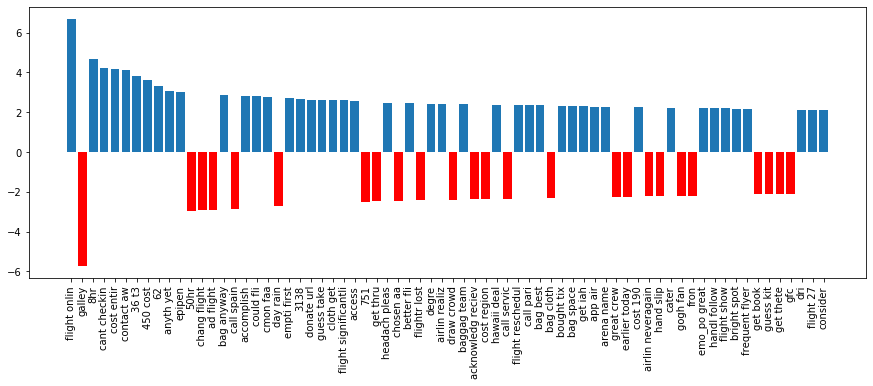

### 1


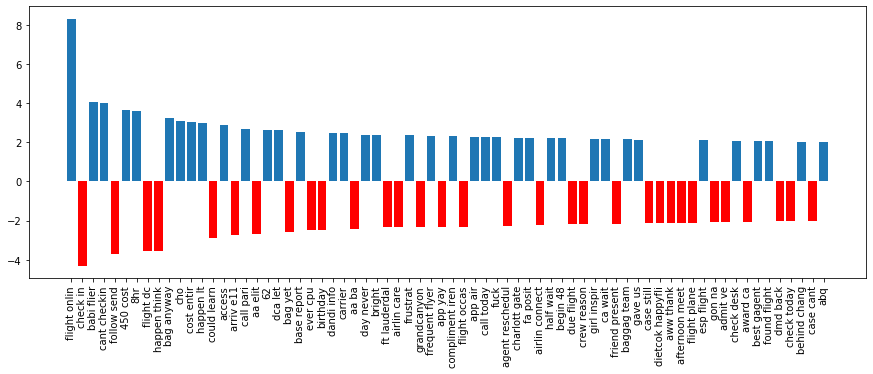

### 2


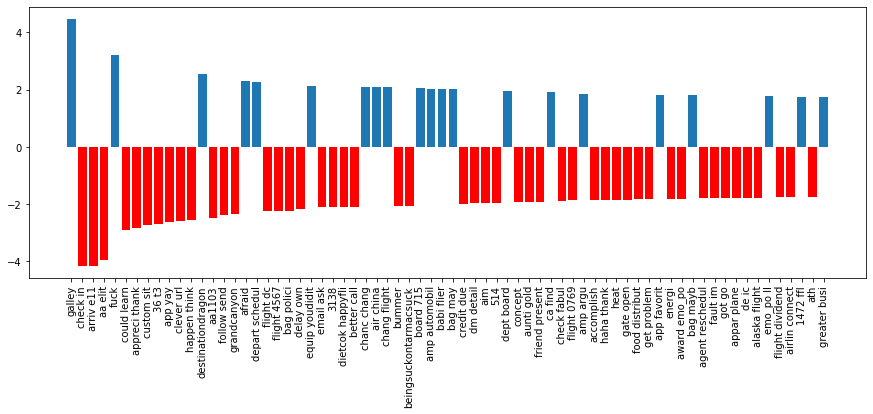

In [37]:
best_n = 70
feature_names = vec.get_feature_names()
for i in range(weights.shape[0]):
    print('### ' + str(i))
    fn = []
    fv = []
    f = [i for i in sorted(zip(map(lambda x: round(x, 4), clf_fs.best_estimator_.coef_[i].data), clf_fs.best_estimator_.coef_[i].indices), reverse=True, key=lambda k: abs(k[0]))][:best_n]
    for j in range(len(f)):
        fn.append(feature_names[f[j][1]])
        fv.append(f[j][0])
        #print(str(feature_names[f[j][1]]) + ': ' + str(f[j][0]))
    fig, ax = plt.subplots(figsize=(15,5))
    plt.bar([i for i in range(best_n) if fv[i]>0], [x for x in fv if x>0])
    plt.bar([i for i in range(best_n) if fv[i]<0], [x for x in fv if x<0], color='r')
    plt.xticks(range(best_n), fn, rotation='vertical')
    plt.show()

## BPEF for sentiment classification

In [38]:
class Dataset:
    
    # input dataset with labels just positive/neutral/negative
    def __init__(self, text, label, feature, ner=False, use_stemmer=False, combine_text_quote=False):
        if feature not in ['word', 'pos', 'swnt']:
            raise ValueError('feature parameter must be in (\'word\', \'pos\', \'swnt\')')
        self.text = text
        self.label = label
        self.feature = feature
        self.ner = ner
        self.use_stemmer = use_stemmer
        self.vec = CountVectorizer(ngram_range=(1,2), lowercase=True)
        self.vectorized_before_fs = None
        self.vectorized_after_fs = None
        self.selected_features = None
        self.features_entropy = None
        # fit model -> transform
        self.__fit()
        self.__feature_selection()
        # apply features selection
        self.selected_features_after_fs = self.selected_features
        self.vectorized_after_fs = self.vectorized_before_fs[:, self.selected_features_after_fs]
        
        
    def __fit(self):
        # preprocess
        self.pp = Preprocessor()
        for i in range(len(self.text)):
            self.text[i] = pp.preprocessText(self.text[i], method=self.feature, use_stemmer=self.use_stemmer, ner=self.ner)
        # vectorization (count vectorizer vediamo)
        self.vectorized_before_fs = self.vec.fit_transform(self.text)
        
            
    def transform(self, text):
        for i in range(len(text)):
            text[i] = self.pp.preprocessText(text[i], method=self.feature, use_stemmer=self.use_stemmer, ner=self.ner)
        # vectorization (count vectorizer vediamo) and feature selection
        vectorized = self.vec.transform(text)[:, self.selected_features_after_fs]
        return vectorized
    
    # https://www3.nd.edu/~rjohns15/cse40647.sp14/www/content/lectures/23%20-%20Decision%20Trees%202.pdf
    # https://pypi.org/project/info-gain/
    def __feature_selection(self):
        self.selected_features = [i for i in range(self.vectorized_before_fs.shape[1])]
        self.features_entropy = []
        
        #H_class = scipy.stats.entropy(self.label.value_counts())
        
        # for each feature calculate information gain
        for feat_idx in range(self.vectorized_before_fs.shape[1]):
            # print
            sys.stdout.write("\r IG: " + str(feat_idx) + '/' + str(self.vectorized_before_fs.shape[1]-1))
            sys.stdout.flush()
            '''
            H_feat = 0
            values = set(np.append(self.vectorized_before_fs[:, feat_idx].data, 0)) # zero added manually bcause sparse matrix is stupid
            # for each value calculate the conditional entropy
            for v in values:
                indexes = [i for i in range(self.vectorized_before_fs.shape[0]) if self.vectorized_before_fs[i, feat_idx] == v]
                feat_list = self.label[indexes]
                # entropy
                feat_prob = len(feat_list) / self.vectorized_before_fs.shape[0]
                H_feat += feat_prob * scipy.stats.entropy(feat_list.value_counts())
            #print(H_feat)
            # information gain of the feature
            IG = H_class - H_feat
            '''
            IG = info_gain.info_gain(self.label, self.vectorized_before_fs[:, feat_idx].toarray().ravel())
            self.features_entropy.append(IG)
            
    def plot_IG_feature(self):
        plot_ig = sorted(self.features_entropy, reverse=True)
        plt.subplots(figsize=(15,5))
        plt.semilogy(range(len(plot_ig)), plot_ig)
        plt.show()
        
    def cut_features(self, cutoff_value):
        # cut and apply features selection
        self.selected_features_after_fs = [i for i in range(len(self.features_entropy)) if self.features_entropy[i] > cutoff_value]
        self.vectorized_after_fs = self.vectorized_before_fs[:, self.selected_features_after_fs]
        

### BPEF

word False
 IG: 24206/24206

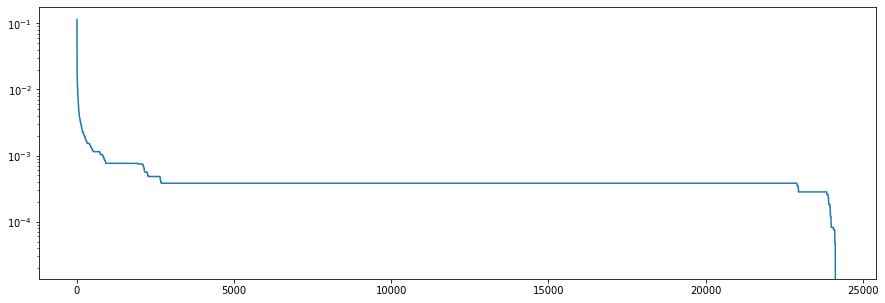

word True
 IG: 22485/22485

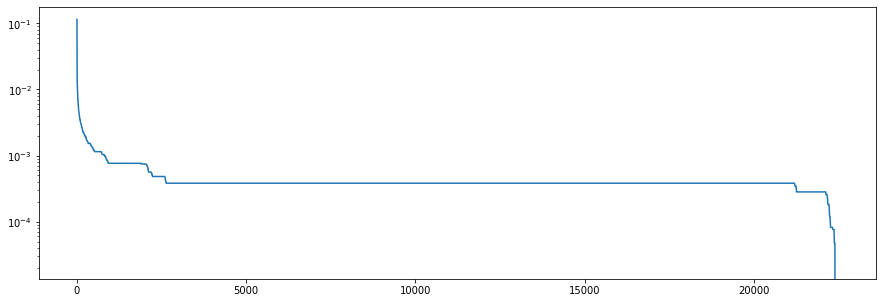

pos False
 IG: 30282/30282

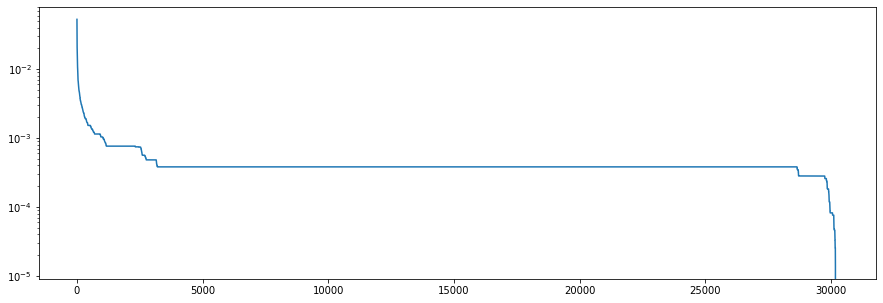

pos True
 IG: 28318/28318

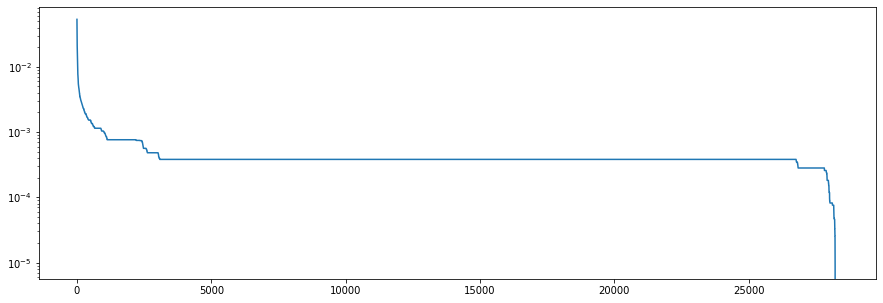

swnt False
 IG: 22789/22789

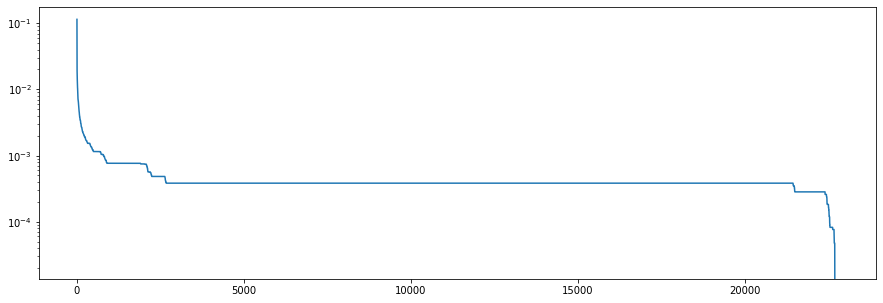

swnt True
 IG: 21133/21133

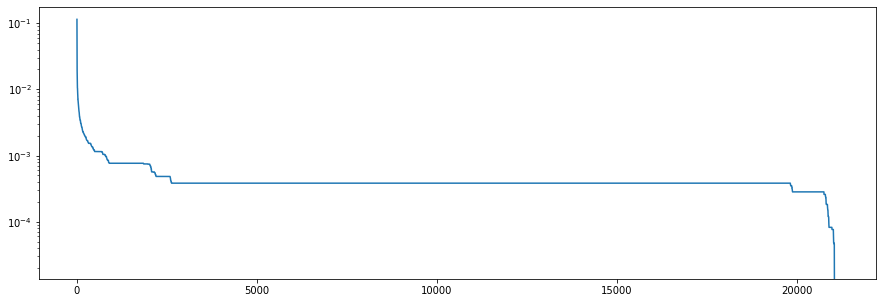

In [39]:
feature_values = ['word', 'pos', 'swnt']
ner_values = [False, True]
column = 'Motore'

train_X_bpef = train_dataset_X
train_y_bpef = train_dataset_y
valid_X_bpef = valid_dataset_X
valid_y_bpef = valid_dataset_y
test_X_bpef = test_dataset_X
test_y_bpef = test_dataset_y


dataset_dict = {}
for f in feature_values:
    for n in ner_values:
        print(f + ' ' + str(n))
        
        d = Dataset(text=train_X_bpef.copy(), label=train_y_bpef.copy(), feature=f, ner=n, use_stemmer=True, combine_text_quote=False)
        
        d.plot_IG_feature()
        dataset_dict[(f, n)] = d


In [40]:
# save dict
with open('pickle/dataset_dict_twitter', 'wb') as f:
    pickle.dump(dataset_dict, f)

In [41]:
with open('pickle/dataset_dict_twitter', 'rb') as f:
    dataset_dict = pickle.load(f)

In [42]:
sorted(dataset_dict[('word', False)].features_entropy, reverse=True)[4000]

0.00038158321935144457

In [43]:
# dataset no feature selection
dataset_dict_nofs = deepcopy(dataset_dict)

In [44]:
# without feature selection
for k in dataset_dict_nofs.keys():
    #dataset_dict_nofs[k].cut_features(0)
    print(str(k) + ' ' + str(len(dataset_dict_nofs[k].selected_features_after_fs)))

('word', False) 24207
('word', True) 22486
('pos', False) 30283
('pos', True) 28319
('swnt', False) 22790
('swnt', True) 21134


In [45]:
class BPEF:
    
    def __init__(self, dict_dataset):
        self.dict_dataset = dict_dataset
        
    # text plain, quote plain, labels numerical
    def train(self, text, labels):
        self.classifiers_dict = {}
        keys = self.dict_dataset.keys()
        classifiers = ['svm', 'logreg', 'rndfst', 'naibay']
        # for each feature type -> keys ('feature', True/False)
        for k in keys:
            d = self.dict_dataset[k]
            # train set
            text_copy = text.copy()

            X = d.transform(text_copy)
            
            # train every classifier
            for c in classifiers:
                print('######## ' + str((k + (c, ))) + ' ########')
                
                if c == 'svm':
                    # train, estimate C with gridsearch
                    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
                    svmclf = svm.SVC(kernel='linear', decision_function_shape='ovr', verbose=2, random_state=42)
                    tuned_parameters = {'C': np.logspace(-3, 3, 7),}
                    clf = GridSearchCV(svmclf, tuned_parameters, cv=skf, n_jobs=-1, scoring='f1_macro', verbose=2)
                    clf.fit(X, labels)
                    print("Best parameters set found on development set:")
                    print()
                    print(clf.best_params_)
                    print()
                    print("Grid scores on development set:")
                    print()
                    means = clf.cv_results_['mean_test_score']
                    stds = clf.cv_results_['std_test_score']
                    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
                        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
                    print()
                    # add classifier to dictionary
                    self.classifiers_dict[k + (c, )] = clf.best_estimator_
                    
                elif c == 'logreg':
                    # train, estimate C with gridsearch
                    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
                    logreg = LogisticRegression(multi_class='ovr', verbose=2, random_state=42)
                    tuned_parameters = {'C': np.logspace(-3, 3, 7)}
                    clf = GridSearchCV(logreg, tuned_parameters, cv=skf, n_jobs=-1, scoring='f1_macro', verbose=2)
                    clf.fit(X, labels)
                    print("Best parameters set found on development set:")
                    print()
                    print(clf.best_params_)
                    print()
                    print("Grid scores on development set:")
                    print()
                    means = clf.cv_results_['mean_test_score']
                    stds = clf.cv_results_['std_test_score']
                    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
                        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
                    print()
                    # add classifier to dictionary
                    self.classifiers_dict[k + (c, )] = clf.best_estimator_
                    
                elif c == 'naibay':
                    # train, estimate C with gridsearch
                    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
                    naibay = GaussianNB()
                    tuned_parameters = {}
                    clf = GridSearchCV(naibay, tuned_parameters, cv=skf, n_jobs=-1, scoring='f1_macro', verbose=2)
                    clf.fit(X.toarray(), labels)
                    print("Best parameters set found on development set:")
                    print()
                    print(clf.best_params_)
                    print()
                    print("Grid scores on development set:")
                    print()
                    means = clf.cv_results_['mean_test_score']
                    stds = clf.cv_results_['std_test_score']
                    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
                        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
                    print()
                    # add classifier to dictionary
                    self.classifiers_dict[k + (c, )] = clf.best_estimator_
                    
                elif c == 'rndfst':
                    # train, estimate C with gridsearch
                    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
                    rndfst = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True)
                    tuned_parameters = {'n_estimators': [201,501], 'max_features': ['auto', 'log2'], 'max_depth' : [10, 100], 'criterion' :['gini', 'entropy']}
                    clf = GridSearchCV(rndfst, tuned_parameters, cv=skf, n_jobs=-1, scoring='f1_macro', verbose=2)
                    clf.fit(X.toarray(), labels)
                    print("Best parameters set found on development set:")
                    print()
                    print(clf.best_params_)
                    print()
                    print("Grid scores on development set:")
                    print()
                    means = clf.cv_results_['mean_test_score']
                    stds = clf.cv_results_['std_test_score']
                    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
                        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
                    print()
                    # add classifier to dictionary
                    self.classifiers_dict[k + (c, )] = clf.best_estimator_
            
        
    # text quote plain
    def predict(self, text):
        text_copy = text.copy()
        predictions = {}
        keys = self.dict_dataset.keys()
        classifiers = ['svm', 'logreg', 'rndfst', 'naibay']
        for k in keys:
            d = self.dict_dataset[k]
            # train set
            text_copy = text.copy()
            X = d.transform(text_copy)
            # train every classifier
            for c in classifiers:
                print('######## ' + str((k + (c, ))) + ' ########')
                # make prediction
                pred = self.classifiers_dict[k + (c, )].predict(X.toarray())
                predictions[k + (c, )] = pred
        # calculate the ensemble
        fin_pred = []
        for i in range(len(text_copy)):
            curr_pred = []
            for k in keys:
                for c in classifiers:
                    curr_pred.append(predictions[k + (c, )][i])
            fin_pred.append(max(set(curr_pred), key = curr_pred.count))
        return fin_pred
                

without feature selection

In [46]:
bpef_nofs = BPEF(dataset_dict_nofs)

In [47]:
bpef_nofs.train(train_X_bpef, train_y_bpef)

######## ('word', False, 'svm') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   10.0s finished


[LibSVM]Best parameters set found on development set:

{'C': 1.0}

Grid scores on development set:

0.408 (+/-0.080) for {'C': 0.001}
0.623 (+/-0.039) for {'C': 0.01}
0.692 (+/-0.054) for {'C': 0.1}
0.700 (+/-0.040) for {'C': 1.0}
0.685 (+/-0.054) for {'C': 10.0}
0.685 (+/-0.055) for {'C': 100.0}
0.685 (+/-0.055) for {'C': 1000.0}

######## ('word', False, 'logreg') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    2.6s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibLinear]Best parameters set found on development set:

{'C': 1.0}

Grid scores on development set:

0.592 (+/-0.029) for {'C': 0.001}
0.652 (+/-0.037) for {'C': 0.01}
0.700 (+/-0.037) for {'C': 0.1}
0.713 (+/-0.048) for {'C': 1.0}
0.710 (+/-0.049) for {'C': 10.0}
0.706 (+/-0.056) for {'C': 100.0}
0.706 (+/-0.057) for {'C': 1000.0}

######## ('word', False, 'rndfst') ########
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 22.3min finished


Best parameters set found on development set:

{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 501}

Grid scores on development set:

0.692 (+/-0.027) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 201}
0.696 (+/-0.020) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 501}
0.618 (+/-0.053) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 201}
0.674 (+/-0.040) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 501}
0.691 (+/-0.043) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 201}
0.688 (+/-0.039) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 501}
0.681 (+/-0.061) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 201}
0.686 (+/-0.054) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estima

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.2s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.3s finished


Best parameters set found on development set:

{}

Grid scores on development set:

0.561 (+/-0.059) for {}

######## ('word', True, 'svm') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   13.5s finished


[LibSVM]Best parameters set found on development set:

{'C': 0.1}

Grid scores on development set:

0.304 (+/-0.104) for {'C': 0.001}
0.594 (+/-0.058) for {'C': 0.01}
0.697 (+/-0.054) for {'C': 0.1}
0.687 (+/-0.063) for {'C': 1.0}
0.678 (+/-0.066) for {'C': 10.0}
0.678 (+/-0.065) for {'C': 100.0}
0.678 (+/-0.065) for {'C': 1000.0}

######## ('word', True, 'logreg') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    1.3s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    2.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibLinear]Best parameters set found on development set:

{'C': 1.0}

Grid scores on development set:

0.623 (+/-0.054) for {'C': 0.001}
0.650 (+/-0.059) for {'C': 0.01}
0.692 (+/-0.048) for {'C': 0.1}
0.711 (+/-0.060) for {'C': 1.0}
0.700 (+/-0.061) for {'C': 10.0}
0.691 (+/-0.056) for {'C': 100.0}
0.688 (+/-0.061) for {'C': 1000.0}

######## ('word', True, 'rndfst') ########
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 23.4min finished


Best parameters set found on development set:

{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 501}

Grid scores on development set:

0.687 (+/-0.051) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 201}
0.690 (+/-0.047) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 501}
0.613 (+/-0.053) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 201}
0.664 (+/-0.038) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 501}
0.686 (+/-0.068) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 201}
0.688 (+/-0.061) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 501}
0.667 (+/-0.068) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 201}
0.675 (+/-0.051) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estima

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.0s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.9s finished


Best parameters set found on development set:

{}

Grid scores on development set:

0.552 (+/-0.047) for {}

######## ('pos', False, 'svm') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   27.7s finished


[LibSVM]Best parameters set found on development set:

{'C': 0.1}

Grid scores on development set:

0.516 (+/-0.052) for {'C': 0.001}
0.617 (+/-0.007) for {'C': 0.01}
0.666 (+/-0.038) for {'C': 0.1}
0.658 (+/-0.042) for {'C': 1.0}
0.651 (+/-0.036) for {'C': 10.0}
0.651 (+/-0.036) for {'C': 100.0}
0.651 (+/-0.036) for {'C': 1000.0}

######## ('pos', False, 'logreg') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    2.3s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    3.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[LibLinear]Best parameters set found on development set:

{'C': 1.0}

Grid scores on development set:

0.512 (+/-0.017) for {'C': 0.001}
0.600 (+/-0.021) for {'C': 0.01}
0.657 (+/-0.020) for {'C': 0.1}
0.671 (+/-0.038) for {'C': 1.0}
0.666 (+/-0.042) for {'C': 10.0}
0.660 (+/-0.052) for {'C': 100.0}
0.660 (+/-0.046) for {'C': 1000.0}

######## ('pos', False, 'rndfst') ########
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 19.1min finished


Best parameters set found on development set:

{'criterion': 'entropy', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 501}

Grid scores on development set:

0.613 (+/-0.030) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 201}
0.628 (+/-0.023) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 501}
0.583 (+/-0.034) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 201}
0.613 (+/-0.038) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 501}
0.622 (+/-0.020) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 201}
0.629 (+/-0.026) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 501}
0.605 (+/-0.034) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 201}
0.622 (+/-0.036) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estim

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.6s remaining:    9.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.8s finished


Best parameters set found on development set:

{}

Grid scores on development set:

0.568 (+/-0.016) for {}

######## ('pos', True, 'svm') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   24.4s finished


[LibSVM]Best parameters set found on development set:

{'C': 0.1}

Grid scores on development set:

0.494 (+/-0.027) for {'C': 0.001}
0.611 (+/-0.029) for {'C': 0.01}
0.662 (+/-0.049) for {'C': 0.1}
0.661 (+/-0.063) for {'C': 1.0}
0.659 (+/-0.063) for {'C': 10.0}
0.659 (+/-0.063) for {'C': 100.0}
0.659 (+/-0.063) for {'C': 1000.0}

######## ('pos', True, 'logreg') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    2.7s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    3.3s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[LibLinear]Best parameters set found on development set:

{'C': 1.0}

Grid scores on development set:

0.519 (+/-0.033) for {'C': 0.001}
0.608 (+/-0.033) for {'C': 0.01}
0.662 (+/-0.042) for {'C': 0.1}
0.676 (+/-0.061) for {'C': 1.0}
0.676 (+/-0.060) for {'C': 10.0}
0.673 (+/-0.055) for {'C': 100.0}
0.672 (+/-0.052) for {'C': 1000.0}

######## ('pos', True, 'rndfst') ########
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 19.7min finished


Best parameters set found on development set:

{'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 501}

Grid scores on development set:

0.641 (+/-0.033) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 201}
0.647 (+/-0.019) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 501}
0.570 (+/-0.072) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 201}
0.629 (+/-0.041) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 501}
0.635 (+/-0.045) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 201}
0.636 (+/-0.054) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 501}
0.626 (+/-0.042) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 201}
0.637 (+/-0.052) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimator

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.1s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.3s finished


Best parameters set found on development set:

{}

Grid scores on development set:

0.559 (+/-0.055) for {}

######## ('swnt', False, 'svm') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   14.3s finished


[LibSVM]Best parameters set found on development set:

{'C': 1.0}

Grid scores on development set:

0.419 (+/-0.047) for {'C': 0.001}
0.627 (+/-0.051) for {'C': 0.01}
0.683 (+/-0.050) for {'C': 0.1}
0.683 (+/-0.050) for {'C': 1.0}
0.670 (+/-0.050) for {'C': 10.0}
0.670 (+/-0.047) for {'C': 100.0}
0.670 (+/-0.047) for {'C': 1000.0}

######## ('swnt', False, 'logreg') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    1.3s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    2.2s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibLinear]Best parameters set found on development set:

{'C': 1.0}

Grid scores on development set:

0.587 (+/-0.030) for {'C': 0.001}
0.644 (+/-0.040) for {'C': 0.01}
0.686 (+/-0.045) for {'C': 0.1}
0.694 (+/-0.061) for {'C': 1.0}
0.694 (+/-0.055) for {'C': 10.0}
0.687 (+/-0.054) for {'C': 100.0}
0.685 (+/-0.044) for {'C': 1000.0}

######## ('swnt', False, 'rndfst') ########
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 20.3min finished


Best parameters set found on development set:

{'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 201}

Grid scores on development set:

0.683 (+/-0.028) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 201}
0.682 (+/-0.032) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 501}
0.603 (+/-0.057) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 201}
0.638 (+/-0.020) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 501}
0.680 (+/-0.039) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 201}
0.679 (+/-0.042) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 501}
0.667 (+/-0.044) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 201}
0.669 (+/-0.033) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimator

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.0s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.0s finished


Best parameters set found on development set:

{}

Grid scores on development set:

0.549 (+/-0.060) for {}

######## ('swnt', True, 'svm') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   14.4s finished


[LibSVM]Best parameters set found on development set:

{'C': 0.1}

Grid scores on development set:

0.340 (+/-0.079) for {'C': 0.001}
0.608 (+/-0.059) for {'C': 0.01}
0.683 (+/-0.055) for {'C': 0.1}
0.671 (+/-0.057) for {'C': 1.0}
0.664 (+/-0.066) for {'C': 10.0}
0.660 (+/-0.066) for {'C': 100.0}
0.660 (+/-0.066) for {'C': 1000.0}

######## ('swnt', True, 'logreg') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    1.3s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    2.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibLinear]Best parameters set found on development set:

{'C': 1.0}

Grid scores on development set:

0.604 (+/-0.059) for {'C': 0.001}
0.642 (+/-0.057) for {'C': 0.01}
0.685 (+/-0.054) for {'C': 0.1}
0.691 (+/-0.056) for {'C': 1.0}
0.685 (+/-0.060) for {'C': 10.0}
0.681 (+/-0.053) for {'C': 100.0}
0.673 (+/-0.057) for {'C': 1000.0}

######## ('swnt', True, 'rndfst') ########
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 21.0min finished


Best parameters set found on development set:

{'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 501}

Grid scores on development set:

0.676 (+/-0.047) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 201}
0.681 (+/-0.045) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 501}
0.624 (+/-0.047) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 201}
0.666 (+/-0.042) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 501}
0.676 (+/-0.050) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 201}
0.676 (+/-0.044) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 501}
0.660 (+/-0.051) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 201}
0.668 (+/-0.057) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimator

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.6s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.6s finished


Best parameters set found on development set:

{}

Grid scores on development set:

0.543 (+/-0.065) for {}



In [48]:
pred_nofs = bpef_nofs.predict(valid_X_bpef)

######## ('word', False, 'svm') ########
######## ('word', False, 'logreg') ########
######## ('word', False, 'rndfst') ########
######## ('word', False, 'naibay') ########
######## ('word', True, 'svm') ########
######## ('word', True, 'logreg') ########
######## ('word', True, 'rndfst') ########
######## ('word', True, 'naibay') ########
######## ('pos', False, 'svm') ########
######## ('pos', False, 'logreg') ########
######## ('pos', False, 'rndfst') ########
######## ('pos', False, 'naibay') ########
######## ('pos', True, 'svm') ########
######## ('pos', True, 'logreg') ########
######## ('pos', True, 'rndfst') ########
######## ('pos', True, 'naibay') ########
######## ('swnt', False, 'svm') ########
######## ('swnt', False, 'logreg') ########
######## ('swnt', False, 'rndfst') ########
######## ('swnt', False, 'naibay') ########
######## ('swnt', True, 'svm') ########
######## ('swnt', True, 'logreg') ########
######## ('swnt', True, 'rndfst') ########
######## ('swnt', True, '

F1 macro score on validation data: 0.7323288065646145
F1 micro score on validation data: 0.7305555555555555


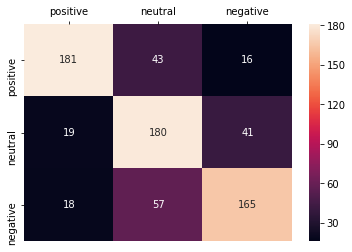

In [49]:
# 0=positivo, 1=neutro, 2=negativo
print('F1 macro score on validation data: ' + str(f1_score(valid_y_bpef, pred_nofs, average='macro')))
print('F1 micro score on validation data: ' + str(f1_score(valid_y_bpef, pred_nofs, average='micro')))
cm_fs_bpef_nofs = confusion_matrix(valid_y_bpef, pred_nofs, labels=[0, 1, 2])
ax = sns.heatmap(cm_fs_bpef_nofs, annot=True, xticklabels=['positive','neutral','negative'], yticklabels=['positive','neutral','negative'],fmt="d")
ax.xaxis.set_ticks_position('top')

In [50]:
# feature selection
# cut less informative features -> cutoff at 0.0019 (heuristic)
for k in dataset_dict.keys():
    dataset_dict[k].cut_features(0.0004)
    print(str(k) + ' ' + str(len(dataset_dict[k].selected_features_after_fs)))

('word', False) 2665
('word', True) 2622
('pos', False) 3181
('pos', True) 3057
('swnt', False) 2657
('swnt', True) 2612


With feature selection

In [51]:
bpef = BPEF(dataset_dict)

In [52]:
bpef.train(train_X_bpef, train_y_bpef)

######## ('word', False, 'svm') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    6.3s finished


[LibSVM]Best parameters set found on development set:

{'C': 0.1}

Grid scores on development set:

0.410 (+/-0.071) for {'C': 0.001}
0.623 (+/-0.035) for {'C': 0.01}
0.712 (+/-0.051) for {'C': 0.1}
0.709 (+/-0.045) for {'C': 1.0}
0.661 (+/-0.034) for {'C': 10.0}
0.633 (+/-0.032) for {'C': 100.0}
0.631 (+/-0.041) for {'C': 1000.0}

######## ('word', False, 'logreg') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    0.9s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.2s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibLinear]Best parameters set found on development set:

{'C': 1.0}

Grid scores on development set:

0.595 (+/-0.029) for {'C': 0.001}
0.657 (+/-0.033) for {'C': 0.01}
0.717 (+/-0.032) for {'C': 0.1}
0.747 (+/-0.037) for {'C': 1.0}
0.732 (+/-0.028) for {'C': 10.0}
0.700 (+/-0.035) for {'C': 100.0}
0.674 (+/-0.040) for {'C': 1000.0}

######## ('word', False, 'rndfst') ########
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  3.0min finished


Best parameters set found on development set:

{'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 201}

Grid scores on development set:

0.675 (+/-0.033) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 201}
0.679 (+/-0.032) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 501}
0.696 (+/-0.038) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 201}
0.703 (+/-0.039) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 501}
0.690 (+/-0.038) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 201}
0.692 (+/-0.032) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 501}
0.708 (+/-0.025) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 201}
0.708 (+/-0.032) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimato

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Best parameters set found on development set:

{}

Grid scores on development set:

0.705 (+/-0.041) for {}

######## ('word', True, 'svm') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    7.0s finished


[LibSVM]Best parameters set found on development set:

{'C': 0.1}

Grid scores on development set:

0.305 (+/-0.110) for {'C': 0.001}
0.594 (+/-0.055) for {'C': 0.01}
0.715 (+/-0.062) for {'C': 0.1}
0.698 (+/-0.044) for {'C': 1.0}
0.650 (+/-0.047) for {'C': 10.0}
0.632 (+/-0.036) for {'C': 100.0}
0.629 (+/-0.034) for {'C': 1000.0}

######## ('word', True, 'logreg') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    0.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.3s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibLinear]Best parameters set found on development set:

{'C': 1.0}

Grid scores on development set:

0.625 (+/-0.054) for {'C': 0.001}
0.656 (+/-0.055) for {'C': 0.01}
0.710 (+/-0.044) for {'C': 0.1}
0.741 (+/-0.052) for {'C': 1.0}
0.722 (+/-0.045) for {'C': 10.0}
0.691 (+/-0.030) for {'C': 100.0}
0.664 (+/-0.021) for {'C': 1000.0}

######## ('word', True, 'rndfst') ########
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  3.3min finished


Best parameters set found on development set:

{'criterion': 'entropy', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 501}

Grid scores on development set:

0.683 (+/-0.048) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 201}
0.679 (+/-0.045) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 501}
0.691 (+/-0.023) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 201}
0.702 (+/-0.043) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 501}
0.698 (+/-0.052) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 201}
0.696 (+/-0.049) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 501}
0.697 (+/-0.058) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 201}
0.699 (+/-0.064) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estim

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Best parameters set found on development set:

{}

Grid scores on development set:

0.696 (+/-0.041) for {}

######## ('pos', False, 'svm') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   19.3s finished


[LibSVM]Best parameters set found on development set:

{'C': 0.1}

Grid scores on development set:

0.516 (+/-0.054) for {'C': 0.001}
0.622 (+/-0.008) for {'C': 0.01}
0.693 (+/-0.028) for {'C': 0.1}
0.658 (+/-0.042) for {'C': 1.0}
0.617 (+/-0.040) for {'C': 10.0}
0.596 (+/-0.033) for {'C': 100.0}
0.566 (+/-0.054) for {'C': 1000.0}

######## ('pos', False, 'logreg') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    1.3s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    2.6s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibLinear]Best parameters set found on development set:

{'C': 1.0}

Grid scores on development set:

0.512 (+/-0.019) for {'C': 0.001}
0.606 (+/-0.024) for {'C': 0.01}
0.679 (+/-0.021) for {'C': 0.1}
0.705 (+/-0.038) for {'C': 1.0}
0.694 (+/-0.051) for {'C': 10.0}
0.657 (+/-0.039) for {'C': 100.0}
0.639 (+/-0.042) for {'C': 1000.0}

######## ('pos', False, 'rndfst') ########
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.6min finished


Best parameters set found on development set:

{'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 501}

Grid scores on development set:

0.621 (+/-0.019) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 201}
0.628 (+/-0.027) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 501}
0.628 (+/-0.021) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 201}
0.641 (+/-0.024) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 501}
0.626 (+/-0.029) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 201}
0.635 (+/-0.024) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 501}
0.634 (+/-0.036) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 201}
0.645 (+/-0.031) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimato

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Best parameters set found on development set:

{}

Grid scores on development set:

0.725 (+/-0.037) for {}

######## ('pos', True, 'svm') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   18.0s finished


[LibSVM]Best parameters set found on development set:

{'C': 0.1}

Grid scores on development set:

0.494 (+/-0.026) for {'C': 0.001}
0.613 (+/-0.039) for {'C': 0.01}
0.691 (+/-0.033) for {'C': 0.1}
0.667 (+/-0.042) for {'C': 1.0}
0.627 (+/-0.038) for {'C': 10.0}
0.608 (+/-0.035) for {'C': 100.0}
0.589 (+/-0.017) for {'C': 1000.0}

######## ('pos', True, 'logreg') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    1.3s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    2.2s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibLinear]Best parameters set found on development set:

{'C': 1.0}

Grid scores on development set:

0.517 (+/-0.036) for {'C': 0.001}
0.615 (+/-0.036) for {'C': 0.01}
0.686 (+/-0.036) for {'C': 0.1}
0.713 (+/-0.038) for {'C': 1.0}
0.702 (+/-0.039) for {'C': 10.0}
0.669 (+/-0.029) for {'C': 100.0}
0.635 (+/-0.028) for {'C': 1000.0}

######## ('pos', True, 'rndfst') ########
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   47.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.7min finished


Best parameters set found on development set:

{'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 501}

Grid scores on development set:

0.633 (+/-0.032) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 201}
0.634 (+/-0.026) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 501}
0.646 (+/-0.028) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 201}
0.657 (+/-0.027) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 501}
0.644 (+/-0.051) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 201}
0.644 (+/-0.046) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 501}
0.655 (+/-0.036) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 201}
0.661 (+/-0.054) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimato

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Best parameters set found on development set:

{}

Grid scores on development set:

0.718 (+/-0.050) for {}

######## ('swnt', False, 'svm') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    7.9s finished


[LibSVM]Best parameters set found on development set:

{'C': 1.0}

Grid scores on development set:

0.417 (+/-0.047) for {'C': 0.001}
0.628 (+/-0.046) for {'C': 0.01}
0.696 (+/-0.051) for {'C': 0.1}
0.699 (+/-0.044) for {'C': 1.0}
0.649 (+/-0.029) for {'C': 10.0}
0.618 (+/-0.041) for {'C': 100.0}
0.603 (+/-0.052) for {'C': 1000.0}

######## ('swnt', False, 'logreg') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    0.9s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.4s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibLinear]Best parameters set found on development set:

{'C': 1.0}

Grid scores on development set:

0.590 (+/-0.027) for {'C': 0.001}
0.647 (+/-0.038) for {'C': 0.01}
0.703 (+/-0.038) for {'C': 0.1}
0.730 (+/-0.045) for {'C': 1.0}
0.717 (+/-0.041) for {'C': 10.0}
0.691 (+/-0.036) for {'C': 100.0}
0.659 (+/-0.029) for {'C': 1000.0}

######## ('swnt', False, 'rndfst') ########
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.9min finished


Best parameters set found on development set:

{'criterion': 'entropy', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 501}

Grid scores on development set:

0.667 (+/-0.048) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 201}
0.665 (+/-0.045) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 501}
0.691 (+/-0.030) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 201}
0.694 (+/-0.031) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 501}
0.679 (+/-0.025) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 201}
0.682 (+/-0.028) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 501}
0.690 (+/-0.047) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 201}
0.695 (+/-0.047) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estim

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Best parameters set found on development set:

{}

Grid scores on development set:

0.696 (+/-0.043) for {}

######## ('swnt', True, 'svm') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    7.8s finished


[LibSVM]Best parameters set found on development set:

{'C': 0.1}

Grid scores on development set:

0.339 (+/-0.073) for {'C': 0.001}
0.607 (+/-0.060) for {'C': 0.01}
0.699 (+/-0.051) for {'C': 0.1}
0.693 (+/-0.044) for {'C': 1.0}
0.637 (+/-0.030) for {'C': 10.0}
0.609 (+/-0.019) for {'C': 100.0}
0.598 (+/-0.020) for {'C': 1000.0}

######## ('swnt', True, 'logreg') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    0.9s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.4s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibLinear]Best parameters set found on development set:

{'C': 1.0}

Grid scores on development set:

0.605 (+/-0.057) for {'C': 0.001}
0.646 (+/-0.061) for {'C': 0.01}
0.702 (+/-0.039) for {'C': 0.1}
0.725 (+/-0.034) for {'C': 1.0}
0.714 (+/-0.044) for {'C': 10.0}
0.677 (+/-0.035) for {'C': 100.0}
0.641 (+/-0.034) for {'C': 1000.0}

######## ('swnt', True, 'rndfst') ########
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   50.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  3.1min finished


Best parameters set found on development set:

{'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 501}

Grid scores on development set:

0.674 (+/-0.046) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 201}
0.676 (+/-0.053) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 501}
0.683 (+/-0.046) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 201}
0.689 (+/-0.042) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 501}
0.690 (+/-0.045) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 201}
0.688 (+/-0.036) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 501}
0.695 (+/-0.056) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 201}
0.695 (+/-0.068) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimato

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Best parameters set found on development set:

{}

Grid scores on development set:

0.686 (+/-0.044) for {}



In [53]:
pred = bpef.predict(valid_X_bpef)

######## ('word', False, 'svm') ########
######## ('word', False, 'logreg') ########
######## ('word', False, 'rndfst') ########
######## ('word', False, 'naibay') ########
######## ('word', True, 'svm') ########
######## ('word', True, 'logreg') ########
######## ('word', True, 'rndfst') ########
######## ('word', True, 'naibay') ########
######## ('pos', False, 'svm') ########
######## ('pos', False, 'logreg') ########
######## ('pos', False, 'rndfst') ########
######## ('pos', False, 'naibay') ########
######## ('pos', True, 'svm') ########
######## ('pos', True, 'logreg') ########
######## ('pos', True, 'rndfst') ########
######## ('pos', True, 'naibay') ########
######## ('swnt', False, 'svm') ########
######## ('swnt', False, 'logreg') ########
######## ('swnt', False, 'rndfst') ########
######## ('swnt', False, 'naibay') ########
######## ('swnt', True, 'svm') ########
######## ('swnt', True, 'logreg') ########
######## ('swnt', True, 'rndfst') ########
######## ('swnt', True, '

F1 macro score on validation data: 0.7527091749910543
F1 micro score on validation data: 0.7513888888888888


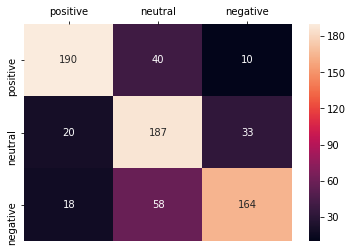

In [54]:
# 0=positivo, 1=neutro, 2=negativo
print('F1 macro score on validation data: ' + str(f1_score(valid_y_bpef, pred, average='macro')))
print('F1 micro score on validation data: ' + str(f1_score(valid_y_bpef, pred, average='micro')))
cm_fs_bpef = confusion_matrix(valid_y_bpef, pred, labels=[0, 1, 2])
ax = sns.heatmap(cm_fs_bpef, annot=True, xticklabels=['positive','neutral','negative'], yticklabels=['positive','neutral','negative'],fmt="d")
ax.xaxis.set_ticks_position('top')

In [55]:
print('positive: ' + str(list(train_y_bpef).count(0)))
print('neutral: ' + str(list(train_y_bpef).count(1)))
print('negative: ' + str(list(train_y_bpef).count(2)))

positive: 960
neutral: 960
negative: 960


Some errors

In [56]:
valid_X_bpef[0]

'@united The link in the message I was replying to. #3thparty #ITproblems'

In [57]:
# positive predicted neutral
err_pos_neu = [i for i in range(len(valid_y_bpef)) if valid_y_bpef[i]==0 and pred[i]==1]
print(valid_X_bpef[err_pos_neu[1]])

@AmericanAir Aww cool! It's nice to know they are still up above my head then. One of my faves.


In [58]:
# neutral predicted positive
err_neu_pos = [i for i in range(len(valid_y_bpef)) if valid_y_bpef[i]==1 and pred[i]==0]
print(valid_X_bpef[err_neu_pos[1]])

@USAirways we got our bags today. Thanks!


In [59]:
# negative predicted neutral
err_neg_pos = [i for i in range(len(valid_y_bpef)) if valid_y_bpef[i]==2 and pred[i]==1]
print(valid_X_bpef[err_neg_pos[3]])

@JetBlue @martysg you *know* how I love you, JB, but honestly, when you have complex feedback, those pull-down sub-option forms=maddening.


### Classification with test data